# AutoEncoder (AE)

In [1]:
# Indagare #e loss e ottimizzatori

In [2]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Hyperparameters

In [3]:
BATCH_SIZE = 8

## Architecture parameters
IMAGE_DIM = 28*28
LATENT_DIM = 2
HIDDEN_DIM = [256, 128, 32, 8]

## Training setup
LR = 1e-2
WEIGHT_DECAY = 1e-6
EPOCHS = 10

## Dataset download and setup

In [4]:
# work on GPUs
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [5]:
## Import Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),                             
])

# train_test_data = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
train_data = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
val_data  = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

#frac = 0.98
#train_data, test_data = torch.utils.data.random_split(train_test_data, [frac, 1-frac], generator=torch.Generator().manual_seed(42))
print(len(train_data))
print(len(  val_data))
#print(len( test_data))

60000
10000


In [6]:
# Filter out images with labels 1 and 7 from the training dataset
indices = (train_data.targets == 1) + (train_data.targets == 7) # this has the same length as train_data.targets, filled with 1 and 0s
indices[8000:] = False  # Limit the number of images with labels 1 and 7
train_data.data, train_data.targets = train_data.data[indices], train_data.targets[indices]

# Same thing for the Validation dataset
indices = (val_data.targets == 1) + (val_data.targets == 7)
indices[4000:] = False
val_data.data, val_data.targets = val_data.data[indices], val_data.targets[indices]

# Same thing for the Test dataset
#indices = (test_data.targets == 1) + (test_data.targets == 7)
#indices[4000:] = False
#test_data.data, test_data.targets = test_data.data[indices], test_data.targets[indices]

print("Train set: ", len(train_data.targets), "samples \nVal   set: ", len(val_data.targets), "samples")
#print("Train set: ", len(train_data.targets), "samples \nVal set: ", len(val_data.targets), "samples \nTest set: ", len(test_data.targets), "samples")

Train set:  1759 samples 
Val   set:  861 samples


In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,    shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data,   batch_size=len(val_data), shuffle=False)
#test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=len(test_data),shuffle=False)

## Dataset visualization

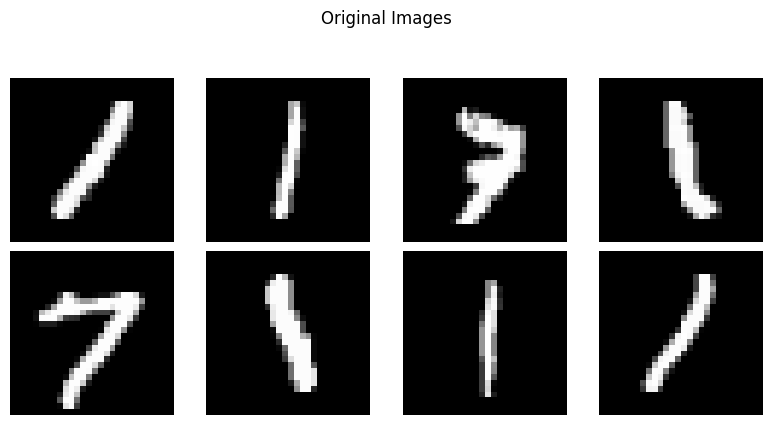

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [8]:
## Plotting utility
def plot_images(images, title):
    plt.figure(figsize=(8, 4)) # they're inches...
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()


## Visualize sample from dataset
with torch.no_grad():
    idx, (images, _) = next(enumerate(train_loader))

plot_images(images, title="Original Images")
plt.show()
print(images[0]) # grey scale in [0,1]

## Model and Training

In [26]:
## Build model
class AE(nn.Module):
    def __init__(self, input_dim, out_dim, latent_dim, hidden_dim=[200,50], tied_weights=False):
        super().__init__()

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        ## Utilities
        self.flatten = nn.Flatten(1,3)
        self.activation = nn.ReLU()

        ## Encoder
        self.encoder = nn.ModuleList([])
        self.encoder.append(nn.Linear(input_dim, hidden_dim[0]))
        if len(hidden_dim) > 1:
            for i in range(len(hidden_dim)-1):
                self.encoder.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                
        self.encoder.append(nn.Linear(hidden_dim[-1], latent_dim))
        
        ## Decoder
        self.decoder = nn.ModuleList([])
        self.decoder.append(nn.Linear(latent_dim, hidden_dim[-1]))
        
        if len(hidden_dim) > 1:
            for i in range(1,len(hidden_dim)):
                self.decoder.append(nn.Linear(hidden_dim[-i], hidden_dim[-i-1]))

        self.decoder.append(nn.Linear(hidden_dim[0], out_dim))
        
        if tied_weights:
            for i in range(len(self.encoder)):
                self.decoder[i].weight = nn.Parameter(self.encoder[-i-1].weight.transpose(0,1))

        ## Out
        self.sigmoid = nn.Sigmoid()
        self.unflatten = nn.Unflatten(1, (1, 28, 28)) # for MNIST images

    def encode(self, x):
        x = self.flatten(x)
        for layer in self.encoder:
            x = layer(x)
            x = self.activation(x)
        
        # AE needs an activation before the latent layer
        z = x
        
        return z

    def decode(self, z):

        for i, layer in enumerate(self.decoder):
            z = layer(z)
            if i != (len(self.decoder)-1): # the last activation needs to be a sigmoid
                z = self.activation(z)
            
        x_rec = self.sigmoid(z)
        x_rec = self.unflatten(x_rec)

        return x_rec

    def forward(self, x):
        z     = self.encode(x)
        x_rec = self.decode(z)

        return x_rec, z 

In [10]:
## Loss definition
def loss(x, x_gen):
    criterion = nn.MSELoss()
    mse = criterion(x, x_gen)
    
    # L1 regularization
    # L1 = torch.sum(torch.abs(z))
    # return mse + lambd*L1
    
    return mse

def lossKL(x, x_gen, z, rho):
    criterion = nn.MSELoss()
    mse = criterion(x, x_gen)
    criterion_reg = nn.BCELoss() # corresponds to Dkl
    # Compute average (over minibatch) activation
    rho_hat = torch.mean(z, axis=0)
    Dkl = criterion_reg(rho*torch.ones_like(rho_hat), rho_hat)

    # volendo possiamo mettere 1 altro hyperparam a controllare il peso relativo...
    return mse + Dkl

In [11]:
## Test cell
a = torch.Tensor([1,2,-3])
b = torch.Tensor(1)
criterion = nn.MSELoss()
criterion(a,b*torch.ones_like(a))
# torch.sum(torch.abs(a))

tensor(4.6667)

In [12]:
model = AE(IMAGE_DIM, IMAGE_DIM, LATENT_DIM, HIDDEN_DIM)
model = model.to(DEVICE)

## Optimizer choice
optimizer = optim.Adam(model.parameters(),
                      lr = LR,
                      weight_decay=WEIGHT_DECAY)

## Model summary
print(model.parameters)

<bound method Module.parameters of AE(
  (flatten): Flatten(start_dim=1, end_dim=3)
  (activation): ReLU()
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
  (sigmoid): Sigmoid()
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)>


### Training

In [13]:
# train loop
loss_train = []
loss_val   = []

for epoch in range(EPOCHS):
    loss_epoch = 0.0
    for x_train, _ in train_loader:
        x_train = x_train.to(DEVICE)
        
        x_gen, z = model(x_train) # in qlche modo qua sa che deve andare a prendere .forward()
        computed_loss = loss(x_gen, x_train)
        #computed_loss = lossKL(x_gen, x_train, z, RHO)
        loss_epoch += computed_loss.detach()
        
        optimizer.zero_grad()
        computed_loss.backward()
        optimizer.step()

    ## Loss record
    loss_epoch /= len(train_loader)
    loss_train.append(loss_epoch)

    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(DEVICE)
            
            x_gen_val, z = model(x_val)
            val_computed_loss = loss(x_gen_val, x_val)
            # val_computed_loss = lossKL(x_gen_val, x_val, z, RHO)
            loss_val.append(val_computed_loss.detach())
            
    print(f"Epoch: {epoch+1:2.0f} -- Loss = {loss_epoch:.5f} -- Val loss = {val_computed_loss:.5f}")

Epoch:  1 -- Loss = 0.04318 -- Val loss = 0.03163
Epoch:  2 -- Loss = 0.03182 -- Val loss = 0.03162
Epoch:  3 -- Loss = 0.02982 -- Val loss = 0.02963
Epoch:  4 -- Loss = 0.02937 -- Val loss = 0.02823
Epoch:  5 -- Loss = 0.02888 -- Val loss = 0.02876
Epoch:  6 -- Loss = 0.02807 -- Val loss = 0.02812
Epoch:  7 -- Loss = 0.02856 -- Val loss = 0.02937
Epoch:  8 -- Loss = 0.02845 -- Val loss = 0.02796
Epoch:  9 -- Loss = 0.02774 -- Val loss = 0.02869
Epoch: 10 -- Loss = 0.02897 -- Val loss = 0.02813


### Visualization

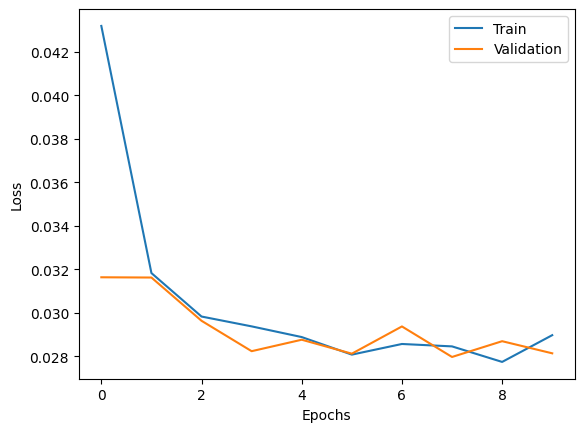

In [14]:
## Train and validation loss curves
plt.plot(loss_train, label = "Train")
plt.plot(loss_val  , label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [15]:
image_iterator = enumerate(train_loader)

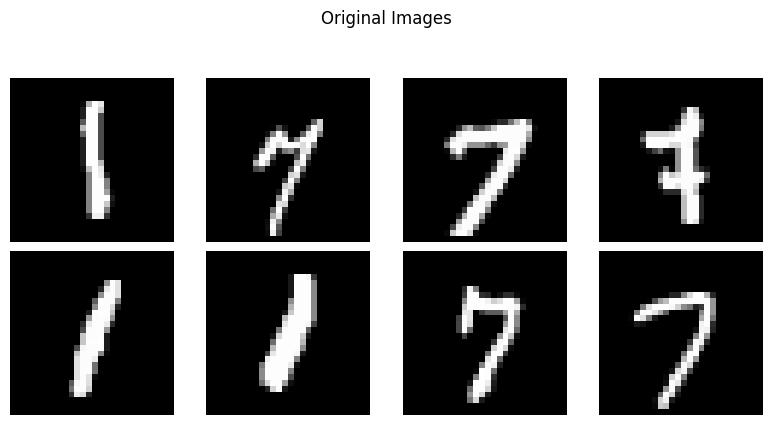

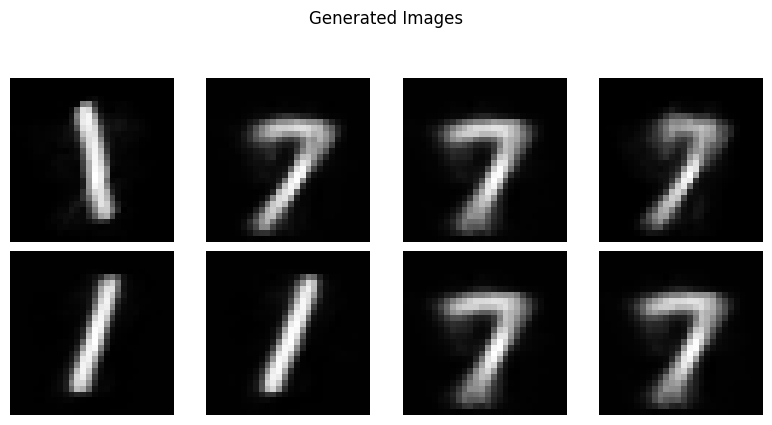

In [16]:
## Compare actual figures
with torch.no_grad():
    idx, (images, _) = next(image_iterator)
    images_gen, z = model(images)
    

plot_images(images, title="Original Images")
plot_images(images_gen, title="Generated Images")
plt.show()

In [17]:
## Sample from latent space
## Generate